In [66]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from typing import Dict, List
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize,normalize
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.ndimage import zoom
from functools import reduce
from scipy.io import loadmat
from skimage.measure import block_reduce
from collections import Counter
from scipy.sparse import coo_matrix,hstack, vstack
import cv2
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.ops as ops
torch.cuda.set_device(2)
print (torch.cuda.current_device())

2


In [2]:
tstart = time.time()
root_dir = '/data/fjsdata/MCBIR-Ins/origa650/' #the path of images
trData = pd.read_csv(root_dir+"trainset.csv" , sep=',')
teData = pd.read_csv(root_dir+"testset.csv" , sep=',')
#trainset 
trN, trI, trM, trY = [],[],[],[]
for iname, itype in np.array(trData).tolist():
    iname=os.path.splitext(iname)[0].strip()[1:] #get rid of file extension
    try:
        trN.append(iname)
        if itype==True: #glaucoma
            trY.append(1)
        else: trY.append(0) #False
        image_path = os.path.join(root_dir, 'images', iname+'.jpg')
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        trI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname+'.mat')
        mask = cv2.resize(loadmat(mask_path)['mask'],(256, 256))#(256,256)
        trM.append(mask)
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(trN),trData.shape[0]))
    sys.stdout.flush()
print('The length of trainset is %d'%len(trN))
#testset
teN, teI, teM, teY = [],[],[],[]
for iname, itype in np.array(teData).tolist():
    iname=os.path.splitext(iname)[0].strip()[1:] #get rid of file extension
    try:
        teN.append(iname)
        if itype==True: #glaucoma
            teY.append(1)
        else: teY.append(0) #False
        image_path = os.path.join(root_dir, 'images', iname+'.jpg')
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        teI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname+'.mat')
        mask = cv2.resize(loadmat(mask_path)['mask'],(256, 256))#(256,256)
        teM.append(mask)
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(teN),teData.shape[0]))
    sys.stdout.flush()
print('The length of testset is %d'%len(teN))

elapsed = time.time() - tstart
print('Completed data handle in %d seconds' % int(elapsed))

585 / 585 The length of trainset is 585
65 / 65 The length of testset is 65
Completed data handle in 102 seconds


In [3]:
model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}

class VGG(nn.Module):

    def __init__(self, features, num_classes=2, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg11(progress=True, **kwargs):
    r"""VGG 11-layer model (configuration "A") from
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['A'], batch_norm=False), **kwargs)
    return model


def vgg11_bn(progress=True, **kwargs):
    r"""VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['A'], batch_norm=True), **kwargs)
    return model


def vgg13(progress=True, **kwargs):
    r"""VGG 13-layer model (configuration "B")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['B'], batch_norm=False), **kwargs)
    return model


def vgg13_bn(progress=True, **kwargs):
    r"""VGG 13-layer model (configuration "B") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['B'], batch_norm=True), **kwargs)
    return model


def vgg16(progress=True, **kwargs):
    r"""VGG 16-layer model (configuration "D")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['D'], batch_norm=False), **kwargs)
    return model


def vgg16_bn(progress=True, **kwargs):
    r"""VGG 16-layer model (configuration "D") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['D'], batch_norm=True), **kwargs)
    return model


def vgg19(progress=True, **kwargs):
    r"""VGG 19-layer model (configuration "E")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['E'], batch_norm=False), **kwargs)
    return model


def vgg19_bn(progress=True, **kwargs):
    r"""VGG 19-layer model (configuration 'E') with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['E'], batch_norm=True), **kwargs)
    return model

 59 / 59 : loss = 0.2935959Eopch:     1 mean_loss = 5.170773
 59 / 59 : loss = 0.284961Eopch:     2 mean_loss = 0.686160
 59 / 59 : loss = 0.596093Eopch:     3 mean_loss = 0.606985
 59 / 59 : loss = 0.443133Eopch:     4 mean_loss = 0.629431
 59 / 59 : loss = 1.083058Eopch:     5 mean_loss = 0.627706
 59 / 59 : loss = 0.393913Eopch:     6 mean_loss = 0.607815
 59 / 59 : loss = 0.868993Eopch:     7 mean_loss = 0.609853
 59 / 59 : loss = 0.751607Eopch:     8 mean_loss = 0.612225
 59 / 59 : loss = 1.091606Eopch:     9 mean_loss = 0.606122
 59 / 59 : loss = 0.685781Eopch:    10 mean_loss = 0.612145
best_loss = 0.606122
 6 / 7 Sensitivity(TPR) of Normal: 1.000000
Sensitivity(TPR) of Glaucoma: 0.000000
AUC (Area Under Curve) of Micro: 0.491071


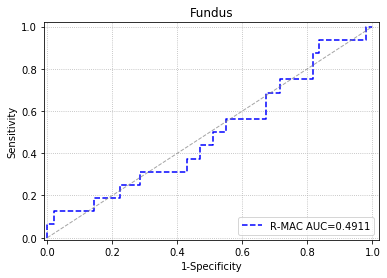

In [8]:
#define model
model = vgg16_bn().cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
ce_loss  = nn.CrossEntropyLoss().cuda() #define cross-entropy loss
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trI)))
    trI_batch = np.array(trI)[shuffled_idx]
    trY_batch = np.array(trY)[shuffled_idx]
    num_batches = len(trI) // batchSize + 1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trI), (i+1)*batchSize])
        X_batch = torch.from_numpy(trI_batch[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_batch[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        Out_batch = model(X_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        loss = ce_loss(Out_batch,Y_batch)#loss
        #backward
        loss.backward()
        optimizer.step()#update parameters
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
#release gpu memory
model = model.cpu()
ce_loss = ce_loss.cpu()
torch.cuda.empty_cache()

#test model
teY_pred = []
teY_prob = []
num_batches = len(teI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    out_batch = F.log_softmax(out_batch,dim=1) 
    prob = out_batch.max(1,keepdim=True)[0]
    teY_prob.extend(prob.cpu().data.numpy().tolist())
    pred = out_batch.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().flatten().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#TNR= TN / (FP+TN) ->low misdiagnosis rate->Specificity
#TPR= TP / (TP+FN) -> low missed diagnosis rate->Sensitivity
#ROC curves: y axis:Sensitivity, x axis:1-Specificity
#confusion matrix
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels) 
print ('Sensitivity(TPR) of Normal: %.6f'%float(cm[0][0]/np.sum(cm[0]))) 
print ('Sensitivity(TPR) of Glaucoma: %.6f'%float(cm[1][1]/np.sum(cm[1])))
#auc and roc
teY_one_hot = label_binarize(np.array(teY), np.arange(len(labels)))
auc_score = roc_auc_score(teY_one_hot, np.array(teY_prob), average='micro')#macro
print ('AUC (Area Under Curve) of Micro: %.6f'% auc_score)
#plot roc curve
fpr_tce, tpr_tce, thresholds = roc_curve(teY_one_hot.ravel(),np.array(teY_prob).ravel()) 
#plt.plot(fpr_ce, tpr_ce, c = 'r', ls = '--', label = u'ATH(our) AUC=%.4f' % auc_score)
plt.plot(fpr_tce, tpr_tce, c = 'b', ls = '--', label = u'R-MAC AUC=%.4f' % auc_score) 
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.2))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.grid(b=True, ls=':')
plt.legend(loc='lower right')
plt.title('Fundus')
plt.show()

In [9]:
#release gpu memory and save model in CPU
model = model.cpu()
ce_loss = ce_loss.cpu()
best_net = best_net.cpu()
torch.cuda.empty_cache() 
torch.save(best_net.state_dict(), '/data/tmpexec/BLCF.pkl')

In [98]:
'''
#Code: https://github.com/imatge-upc/salbow/tree/master/src/BLCF
       https://github.com/imatge-upc/retrieval-2016-icmr
#Paper: CBMI2018《Saliency Weighted Convolutional Features for Instance Search》
        ICMR2016《Bags of local convolutional features for scalable instance search》
'''

#load model and transfer to GPU
device = torch.device("cuda")
best_net = vgg16_bn()
best_net.load_state_dict(torch.load( '/data/tmpexec/BLCF.pkl'))
best_net.to(device)
#1. Extract features based on backbone and Aggregate R-MAC
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
best_net.features.register_forward_hook(get_activation('features'))

# get codebook
def get_codebook(ConvFeat, n_clusters=1000, n_components=100):
    """
    Compute PCA and codebook models
    arg: n_clusters --  size of vocabulary
         n_components -- dim PCA model / None if not computing PCA
    """
    print ("computing PCA-w...")
    training_feats  = []
    for i in range(len(ConvFeat)):
        feat = np.transpose( np.array(ConvFeat[i]), (1,2,0) )
        r, c, ch = feat.shape
        feat = np.reshape( feat, (r*c, -1) )
        training_feats.extend(feat)
    training_feats = np.array(training_feats)
    training_feats = normalize(training_feats)
    t0 = time.time()
    pca_model = PCA(n_components, whiten=True)
    pca_model.fit(training_feats)
    t1 = time.time()
    print ("DONE! %.2fs" % (t1-t0))

    training_feats = pca_model.transform(training_feats)
    print ("Fitting vocabulary")
    t0 = time.time()
    kmeans =KMeans(n_clusters=n_clusters, random_state=0).fit(training_feats)
    t1 = time.time()
    print ("DONE! %.2fs" % (t1-t0))

    return pca_model, kmeans #kmeans.cluster_centers_

batchSize=10
trF = []
num_batches = len(trI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(trI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    feat_batch = activation['features'].squeeze()
    trF.extend(feat_batch.cpu().numpy().tolist())
    
teF = []
num_batches = len(teI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    feat_batch = activation['features'].squeeze()
    teF.extend(feat_batch.cpu().numpy().tolist())
    
pca_model, kmeans = get_codebook(trF)

computing PCA-w...
DONE! 0.74s
Fitting vocabulary
DONE! 298.17s


In [103]:
def get_bow( assignments, weights, n=1000):
    '''
    Funtion to build BoW representation given an assignment map.
    args:
        assignments - 2D map with assignments associated to each local feature
        weights     - 2D maps with normalized (0-1) spatial weighting scheme
        n           - size of the visual vocabulary (default 1000)
    '''
    # sparse encoding !
    rows = np.array([], dtype=np.int)
    cols = np.array([], dtype=np.int)
    vals = np.array([], dtype=np.float)
    n_docs = 0

    # get counts
    cnt = Counter(assignments.flatten())
    ids = list(cnt.keys())#np.array(cnt.keys())
    weights = weights.flatten()
    weights = np.array([weights[np.where(assignments.flatten()==i)[0]].sum() for i in ids])

    #save index
    cols = np.append( cols, np.array(ids).astype(int) )
    rows = np.append( rows, np.ones( len(cnt.keys()), dtype=int )*n_docs )
    vals = np.append( vals, weights.astype(float) )
    n_docs +=1

    bow = coo_matrix( ( vals, (rows, cols) ), shape=(n_docs,n) )
    bow = bow.tocsr()
    #    bow = normalize(bow)
    return bow
#trainset
for i in range(len(trF)):
    feat = np.array(trF[i])
    mask = np.array(trI[i])
    #assignments maps
    #feat = zoom(feat, (1,32,32), order=1) #interpolate=256/8=32
    feat = np.reshape( feat, (feat.shape[0], -1) )
    feat = np.transpose( feat, (1,0) )
    feat = normalize(feat)
    feat = pca_model.transform(feat)
    feat = normalize(feat)
    assigns = kmeans.predict(feat)
    #Normalized saliency
    mask = block_reduce( mask[:,:,0], (32,32), np.max )#downsample
    mask = mask.astype(np.float32)
    if not np.any(mask):
        mask[...]=1
    mask = mask / mask.max()
    #get bags of words
    bow = get_bow(assigns, mask)
    if i == 0:
        tr_bow = bow
    else:
        tr_bow = vstack( [tr_bow, bow] )
tr_bow = normalize(tr_bow)
print(tr_bow.shape)
#testset
for i in range(len(teF)):
    feat = np.array(teF[i])
    mask = np.array(teI[i])
    #assignments maps
    #feat = zoom(feat, (1,32,32), order=1) #interpolate=256/8=32
    feat = np.reshape( feat, (feat.shape[0], -1) )
    feat = np.transpose( feat, (1,0) )
    feat = normalize(feat)
    feat = pca_model.transform(feat)
    feat = normalize(feat)
    assigns = kmeans.predict(feat)
    #Normalized saliency
    mask = block_reduce( mask[:,:,0], (32,32), np.max )#downsample
    mask = mask.astype(np.float32)
    if not np.any(mask):
        mask[...]=1
    mask = mask / mask.max()
    #get bags of words
    bow = get_bow(assigns, mask)
    if i == 0:
        te_bow = bow
    else:
        te_bow = vstack( [te_bow, bow] )
te_bow = normalize(te_bow)
print(te_bow.shape)

#evaluate
#compute the size of lesion
def Func_IOU_size(pred,target,n_classes = 3 ):
    ious = []
    # ignore IOU for background class
    for cls in range(1,n_classes):
        pred_inds = pred == cls
        pred_sum = pred_inds.sum()
        target_inds = target == cls
        target_sum = target_inds.sum()
        ious.append(round(float(min(pred_sum,target_sum)/max(pred_sum,target_sum)),4))
    return np.mean(ious)
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(1000) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(tr_bow.toarray(), dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:
    mAP = [] #mean average precision
    mIoU = []
    scores, neighbors = gpu_index.search(te_bow.toarray().astype('float32'), k=topk)
    for i, teVal in enumerate(te_bow.toarray().tolist()):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                pos_len = pos_len +1
                mAP.append(pos_len/rank_len) 
            else: 
                mAP.append(0)
            mIoU.append(Func_IOU_size(teM[i],trM[j]))
    print("mAP={:.4f}, mIoU={:.4f}".format(np.mean(mAP),np.mean(mIoU)))

(585, 1000)
(65, 1000)
Completed buliding index in 1 seconds
mAP=0.4520, mIoU=0.7197


In [100]:
best_net = best_net.cpu()
x_batch = x_batch.cpu()
torch.cuda.empty_cache() 

In [17]:
datas = pd.read_csv(root_dir+"labels.csv" , sep=',')
datas = datas[['filename','diagnosis(glaucoma=True)']]
print(datas['diagnosis(glaucoma=True)'].value_counts())
trData, teData = train_test_split(datas, test_size=0.1) #split trainset and testset
print(trData['diagnosis(glaucoma=True)'].value_counts())
print(teData['diagnosis(glaucoma=True)'].value_counts())
trData.to_csv( '/data/fjsdata/MCBIR-Ins/origa650/trainset.csv',index=False)
teData.to_csv( '/data/fjsdata/MCBIR-Ins/origa650/testset.csv',index=False)

False    482
True     168
Name: diagnosis(glaucoma=True), dtype: int64
False    433
True     152
Name: diagnosis(glaucoma=True), dtype: int64
False    49
True     16
Name: diagnosis(glaucoma=True), dtype: int64
